In [70]:
import pandas as pd
from tqdm import tqdm

In [2]:
from src.model.city import City
from src.simulation.simulation import Simulation, time_of_number_of_days
from src.data_processing import bikes_scoring, station_changes, processing_constants

In [3]:
city = City.from_numbers(100, 10).assign_bikes_randomly()
time = time_of_number_of_days(7)
simulaiton = Simulation()

simulaiton.simulate(city, time)

simulating: 100%|████████████████████████| 2016/2016 [00:00<00:00, 2755.90it/s]


In [4]:
broken_bikes = simulaiton.get_breaking_bikes_data()
trips_history = simulaiton.get_stations_data()

In [5]:
scores = bikes_scoring.BikesScoring(station_changes.StationChanges(trips_history).find_stations_changes()).score_bikes()

scoring bikes: 100%|███████████████████| 20150/20150 [00:02<00:00, 7214.51it/s]


In [6]:
scores

,bike_id,timestamp,plus,minus
0,65,1,0,0.111111
1,67,1,0,0.111111
2,35,1,0,0.111111
3,39,1,0,0.111111
4,75,1,0,0.111111
...,...,...,...,...
90142,78,2014,0,0.100000
90143,79,2014,0,0.100000
90144,85,2014,0,0.100000
90145,94,2014,0,0.100000


In [89]:
def map_timestamp(time: int, aggregate_hours: int) -> int:
    return int(time/aggregate_hours)

In [7]:
def aggregate_results(df: pd.DataFrame, aggregate_hours: int) -> pd.DataFrame:
    df["time_group"] = df["timestamp"].apply(lambda x: int(x/aggregate_hours))
    agg = scores.drop(["timestamp"], axis=1).groupby(["bike_id", "time_group"]).sum()
    agg["total"] = agg.plus - agg.minus
    return agg

In [16]:
import seaborn as sns

In [17]:
aggregate_time = 12
aggregates = aggregate_results(scores, aggregate_time)

In [18]:
2 in broken_bikes.bike_id.values

True

In [19]:
broken_bikes[broken_bikes.bike_id==2].timestamp/aggregate_time

5    39.333333
Name: timestamp, dtype: float64

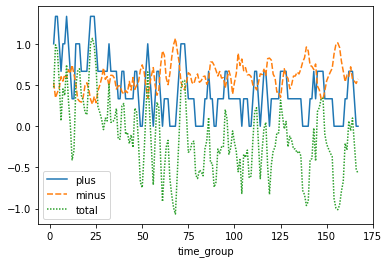

In [20]:
sns.lineplot(data=aggregates.loc[2].rolling(3).mean())

In [21]:
5 in broken_bikes.bike_id.values

False

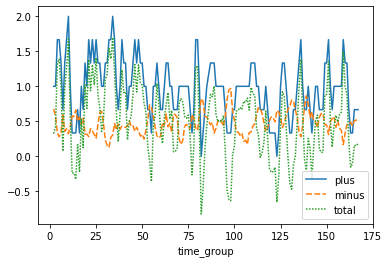

In [22]:
sns.lineplot(data=aggregates.loc[5].rolling(3).mean())

In [23]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression

In [37]:
aggregates.reset_index().sort_values(["time_group"])

,bike_id,time_group,plus,minus,total
0,0,0,1,0.544444,0.455556
4703,28,0,1,0.160256,0.839744
4871,29,0,1,0.361111,0.638889
5039,30,0,0,0.342075,-0.342075
5207,31,0,1,0.258741,0.741259
...,...,...,...,...,...
15956,94,167,0,0.699747,-0.699747
1174,6,167,1,0.501166,0.498834
7054,41,167,0,0.442075,-0.442075
9572,56,167,1,0.410714,0.589286


In [93]:
translated_broken_bikes = broken_bikes.copy()
translated_broken_bikes.timestamp = \
    translated_broken_bikes.timestamp.apply(lambda x: map_timestamp(x, aggregate_time))
translated_broken_bikes

,timestamp,bike_id
0,0,58
1,6,96
2,7,15
3,25,99
4,28,38
5,39,2
6,56,77
7,58,21
8,64,24
9,72,4


In [94]:
bikes_checking = bikes_scoring.BikesChecking(translated_broken_bikes, scores.bike_id.unique())
bikes_checking.bikes_states(99)

65     True
67     True
35     True
39     True
75     True
      ...  
46     True
3      True
19     True
66     True
96    False
Name: valid, Length: 100, dtype: bool

In [95]:
temp = aggregates.groupby(["time_group", "bike_id"]).sum()
temp["is_valid"] = True
time_table = [t[0] for t in aggregates.index]

tqdm.pandas("validation of bikes")

for t in tqdm(time_table):
    states = bikes_checking.bikes_states(t)
    time_df = temp.loc[t]
    
    intersection = set(time_df.index.values) & set(states.index.values)
    
    temp.loc[t].loc[intersection, "is_valid"] = states.loc[intersection]

  0%|                                                | 0/16797 [00:00<?, ?it/s]c:\users\wojciech\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|███████████████████████████████████| 16797/16797 [02:05<00:00, 133.78it/s]


In [102]:
temp.loc[~temp.loc[:, "is_valid"]].tail(50)

plus     minus     total  is_valid
time_group bike_id                                    
95         96          1  0.633333  0.366667     False
           99          0  0.702381 -0.702381     False
96         2           0  0.928716 -0.928716     False
           4           0  0.499145 -0.499145     False
           15          0  0.863889 -0.863889     False
           21          1  0.595238  0.404762     False
           24          0  0.863889 -0.863889     False
           31          1  0.917605  0.082395     False
           38          0  0.785714 -0.785714     False
           58          0  0.476190 -0.476190     False
           77          0  1.342857 -1.342857     False
           83          1  0.416667  0.583333     False
           96          0  0.785714 -0.785714     False
           99          0  1.128716 -1.128716     False
97         2           0  0.586111 -0.586111     False
           4           1  0.503846  0.496154     False
           15          1  0.294444  0.705556     False
           21          1  0.400000  0.600000     False
           24          0  0.568687 -0.568687     False
           31          0  0.457576 -0.457576     False
           38          0  0.932540 -0.932540     False
           58          0  0.619048 -0.619048     False
           77          0  0.775000 -0.775000     False
           83          0  0.476190 -0.476190     False
           96          0  0.932540 -0.932540     False
           99          1  0.486111  0.513889     False
98         2           1  0.274242  0.725758     False
           4           0  0.476263 -0.476263     False
           15          0  1.119048 -1.119048     False
           21          0  0.361111 -0.361111     False
           24          0  0.879304 -0.879304     False
           31          1  0.382479  0.617521     False
           38          0  1.119048 -1.119048     False
           58          0  0.836111 -0.836111     False
           77          1  0.533333  0.466667     False
           83          0  0.836111 -0.836111     False
           96          0  1.119048 -1.119048     False
           99          0  0.236111 -0.236111     False
99         2           0  0.310689 -0.310689     False
           4           0  0.705711 -0.705711     False
           15          0  0.486111 -0.486111     False
           21          1  0.934524  0.065476     False
           24          1  0.385714  0.614286     False
           31          0  1.534524 -1.534524     False
           38          0  0.486111 -0.486111     False
           58          1  0.578968  0.421032     False
           77          0  0.547222 -0.547222     False
           83          0  0.690079 -0.690079     False
           96          0  0.486111 -0.486111     False
           99          0  0.994048 -0.994048     False